In [6]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *
# from proc_revisions.mane_utils import *

In [7]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [8]:
ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='human')[0]
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]
t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='human')[0]
lib_meta = od+expand(config['lr']['meta'], species='human')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species='human')[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='human', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='human')[0]
major_isos = od+expand(config['lr']['analysis']['major_isos'], species='human', obs_col='sample')[0]
pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='human', obs_col='sample')[0]

ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='human')[0]
ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]

talon_ref_gtf = od+expand(config['ref']['talon']['gtf'], species='human')[0]
# pp_summary = '../'+expand(config['data']['p_pred']['summary'], species='human')[0]

ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'polya'
obs_col = 'sample'
go_gene_subset = 'protein_coding'
predom_iso_subset = 'protein_coding'
dist_gene_subset = 'protein_coding'

m_lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]

## 240111 how frequently do the changes result in a change in sector?

In [4]:
dist_summ_file = '/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/data/human/lr/param_search/dist_summary.tsv'

In [43]:
column_names = [
    'gid', 'n_tss', 'n_tes', 'n_ic', 'n_iso', 'splicing_ratio',
    'tss_ratio', 'tes_ratio', 'spl_ratio', 'sector', 'tss_dist',
    'tes_dist', 'tss_slack', 'tes_slack', 'tss_agg_dist', 'tes_agg_dist',
    'gid_stable', 'source_obs', 'n_tss_obs', 'n_tes_obs', 'n_ic_obs',
    'n_iso_obs', 'splicing_ratio_obs', 'tss_ratio_obs', 'tes_ratio_obs',
    'spl_ratio_obs', 'sector_obs', 'dist', 'z_score', 'comparison',
    'same_sect'
]
col_nums = [0, 10, 11, 12, 13, 14, 15, 27, 28, 29, 30]
len(column_names)

31

In [44]:
col_nums

[0, 10, 11, 12, 13, 14, 15, 27, 28, 29, 30]

In [95]:
# df = pd.read_csv(dist_summ_file, usecols=col_nums, nrows=40000, sep='\t')
# df = pd.read_csv(dist_summ_file,usecols=[10,11,12,13,24,15,27,28,29,30],sep='\t',nrows=40000)
df = pd.read_csv(dist_summ_file,usecols=col_nums,sep='\t')
df.head()

,gid,tss_dist,tes_dist,tss_slack,tes_slack,tss_agg_dist,tes_agg_dist,dist,z_score,comparison,same_sect
0,ENSG00000000003,0,0,0,0,0,0,0.184642,0.524752,det,True
1,ENSG00000000005,0,0,0,0,0,0,0.000000,-1.587093,det,True
2,ENSG00000000419,0,0,0,0,0,0,0.243257,1.195151,det,True
3,ENSG00000000457,0,0,0,0,0,0,0.102889,-0.410303,det,False
4,ENSG00000000460,0,0,0,0,0,0,0.132749,-0.068773,det,True


In [ ]:
p = 'tss_dist'
temp = df[[p, 'same_sect', 'comparison', 'gid']].groupby([p, 'same_sect', 'comparison']).nunique().reset_index()

In [ ]:
#    tss_dist  same_sect comparison  n_genes
# 0         0      False        det    11821

In [114]:
temp = df[params+['same_sect', 'comparison', 'gid']].groupby(params+['same_sect', 'comparison']).count().reset_index()
temp.rename({'gid':'n_genes'}, axis=1, inplace=True)
temp = temp.merge(temp[params+['n_genes', 'comparison']].groupby(params+['comparison']).sum().reset_index().rename({'n_genes': 'n_genes_run_total'}, axis=1),
                                                                 how='left',
                                                                 on=params+['comparison'])
temp['perc'] = (temp['n_genes']/temp['n_genes_run_total'])*100

In [116]:
temp = temp.loc[temp.same_sect==True]

> <ipython-input-105-da839265eb5c>(8)<module>()
      6     temp.rename({'gid':'n_genes'}, axis=1, inplace=True)
      7     import pdb; pdb.set_trace()
----> 8     temp = temp.merge(temp[['n_genes', p, 'comparison']].groupby([p, 'comparison']).sum().reset_index().rename({'n_genes':'n_genes_com'}, axis=1),
      9                       how='left',
     10                       on=[p, 'comparison'])



ipdb>  temp.head()


   tss_dist  same_sect comparison  n_genes
0         0      False        det    11821
1         0      False      major    11058
2         0       True        det    16777
3         0       True      major    16696
4        25      False        det     8742


ipdb>  q


BdbQuit: 

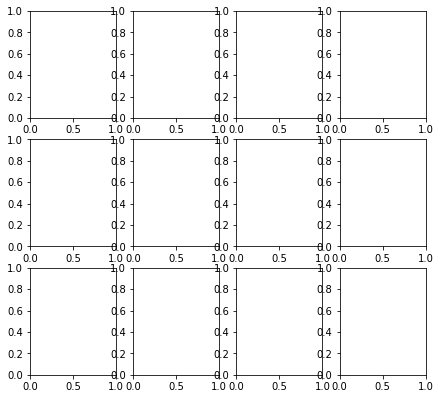

In [105]:
mm = 0.0393701  # mm in inches
fig, axs = plt.subplots(3,4, squeeze=True, figsize=(180*mm, 170*mm))
params = ['tss_dist', 'tes_dist', 'tss_slack', 'tes_slack', 'tss_agg_dist', 'tes_agg_dist']
for p in params:
#     temp = df[[p, 'same_sect', 'comparison', 'gid']].groupby([p, 'same_sect', 'comparison']).nunique().reset_index()
#     temp.rename({'gid':'n_genes'}, axis=1, inplace=True)
#     temp = temp.merge(temp[['n_genes', p, 'comparison']].groupby([p, 'comparison']).sum().reset_index().rename({'n_genes':'n_genes_com'}, axis=1),
#                       how='left',
#                       on=[p, 'comparison'])
#     temp['perc'] = (temp['n_genes']/temp['n_genes_com'])*100
#     temp = temp.loc[temp.same_sect==True]
    
#     temp = temp.sort_values(by=p, ascending=True)
    x_order = temp[p].unique().tolist()
    
    for comp in ['det', 'major']:
        temp2 = temp.loc[temp.comparison==comp].copy(deep=True)
        
        # j coord ( col )
        if 'tss' in p: j = 0
        elif 'tes' in p: j = 2
        if comp == 'major': j += 1
        
        # i coord ( row )
        if 'dist' in p: i = 0
        if 'slack' in p: i = 1
        if 'agg_dist' in p: i = 2
        
        sns.barplot(temp2, x=p, y='perc',
                 order=x_order, ax=axs[i][j])

In [83]:
temp

,tss_dist,same_sect,comparison,n_genes,n_genes_com,perc
2,0,True,det,16777,28598,58.664942
3,0,True,major,16696,27754,60.157094
6,25,True,det,17313,26055,66.447899
7,25,True,major,17277,25767,67.050879
10,100,True,det,16935,24949,67.878472
11,100,True,major,16902,24681,68.481828


In [94]:
# from itertools import product

# x = p
# y = 'perc'
# col = 'comparison'

# col_order = ['det', 'major']
# x_order = temp.sort_values(by=p, ascending=True)[p].unique().tolist()
# bar_order = product(col_order, x_order)

# ax = sns.catplot(temp, x=p, y=y, col=col, kind='bar',
#                  col_order=col_order,
#                  order=x_order)
# pots = zip(ax.patches, bar_order)
# for spot in spots:
#     class_total = len(temp[temp[x]==spot[1][0]])
#     class_who_total = len(temp[(titanic[x]==spot[1][0]) & 
#         (temp[col]==spot[1][1])])
#     height = spot[0].get_height() 
#     catp.ax.text(spot[0].get_x(), height+3, '{:1.2f}'.format(class_who_total/class_total))

In [93]:
ax

## 240109 dev

In [110]:
trip_file = '~/mortazavi_lab/data/paper_rnawg/proc_revisions/data/human/lr/param_search/0_0_25_0_20_0/sample_triplets.tsv'
ofile = '~/mortazavi_lab/data/paper_rnawg/proc_revisions/data/human/lr/param_search/0_0_25_0_20_0/triplet_dists.tsv'

In [105]:
trip_df = pd.read_csv(trip_file, sep='\t')
# trip_df = pd.read_csv(input.trip_file, sep='\t')

# ca = cerberus.read(input.h5)
ca = cerberus.read(cerberus_h5)
ref_trip_back = ca.triplets.copy(deep=True)

df = pd.DataFrame()
df['file'] = [trip_file]
# df['file'] = list(input.trip_file)

df['temp'] = df.file.str.rsplit('/', n=2, expand=True)[1]
temp2 = df.temp.str.split('_', expand=True)
cols = ['tss_dist', 'tes_dist',
        'tss_slack', 'tes_slack',
        'tss_agg_dist', 'tes_agg_dist']
temp2.columns = cols
df.drop('temp', axis=1, inplace=True)
df = pd.concat([df, temp2], axis=1)
df['merge_col'] = 1

# restrict to obs_det and obs_major
print(len(trip_df.index))
trip_df = trip_df.loc[trip_df.source.isin(['obs_det', 'obs_major'])]
print(len(trip_df.index))
trip_df['merge_col'] = 1

# add the metadata
trip_df = trip_df.merge(df, how='left', on='merge_col')

# rename source
param_combo = trip_df['tss_dist'].astype(str)+'_'+\
               trip_df['tes_dist'].astype(str)+'_'+\
               trip_df['tss_slack'].astype(str)+'_'+\
               trip_df['tes_slack'].astype(str)+'_'+\
               trip_df['tss_agg_dist'].astype(str)+'_'+\
               trip_df['tes_agg_dist'].astype(str)

assert len(param_combo.unique().tolist()) == 1
param_combo = param_combo.unique().tolist()[0]

trip_df['source'] = trip_df['source']+'_'+param_combo
               
trip_df.drop('merge_col', axis=1, inplace=True)

# loop through det and major
all_dist_df = pd.DataFrame()
for param_source in trip_df.source.unique():
    if 'major' in param_source:
        ref_source = 'obs_major'
        comp = 'major'
    else:
        ref_source = 'obs_det'
        comp = 'det'
    ca.triplets = pd.concat([trip_df, ref_trip_back], axis=0)
    dist_df = compute_dists([ca, ca],
                   [param_source, 
                   ref_source],
                   gene_subsets=[dist_gene_subset, dist_gene_subset],
                   ver=[ver,  ver],
                   gene_merge=['gid', 'gid'])
    
    # formatting
    dist_df.drop('source_'+param_source, axis=1, inplace=True)
    dist_df['source'] = param_source
    dist_df['comparison'] = comp
    new_cols = [c if param_combo not in c else c.split('_'+ref_source+'_'+param_combo)[0] for c in dist_df.columns]
    dist_df.columns = new_cols
    new_cols = [c if ref_source not in c else c.split('_'+ref_source)[0]+'_obs' for c in dist_df.columns]
    dist_df.columns = new_cols
    dist_df['same_sect'] = dist_df['sector'] == dist_df['sector_obs']
    drop_cols = ['gname', 'sample', 'gene_tpm', 'file', 'biotype', 'gname_obs', 
                 'sample_obs', 'gene_tpm_obs', 'file_obs', 'tss_dist_obs',
                 'tes_dist_obs', 'tss_slack_obs', 'tes_slack_obs', 'tss_agg_dist_obs',
                 'tes_agg_dist_obs', 'gid_stable_obs', 'biotype_obs','source']
    dist_df.drop(drop_cols, axis=1, inplace=True)
    
    
    all_dist_df = pd.concat([all_dist_df, dist_df], axis=0)
all_dist_df.to_csv(ofile, sep='\t', index=False)

1559580
53102


In [109]:
all_dist_df[['comparison', 'gid', 'same_sect']].groupby(['comparison', 'same_sect']).count().reset_index()

,comparison,same_sect,gid
0,det,False,5610
1,det,True,11819
2,major,False,5440
3,major,True,11989


In [103]:
drop_cols = ['gname', 'sample', 'gene_tpm', 'file', 'biotype', 'gname_obs', 
             'sample_obs', 'gene_tpm_obs', 'file_obs', 'tss_dist_obs',
             'tes_dist_obs', 'tss_slack_obs', 'tes_slack_obs', 'tss_agg_dist_obs',
             'tes_agg_dist_obs', 'gid_stable_obs', 'biotype_obs']
dist_df.drop(drop_cols, axis=1, inplace=True)

In [104]:
dist_df.columns

Index(['gid', 'n_tss', 'n_tes', 'n_ic', 'n_iso', 'splicing_ratio', 'tss_ratio',
       'tes_ratio', 'spl_ratio', 'sector', 'tss_dist', 'tes_dist', 'tss_slack',
       'tes_slack', 'tss_agg_dist', 'tes_agg_dist', 'gid_stable', 'source_obs',
       'n_tss_obs', 'n_tes_obs', 'n_ic_obs', 'n_iso_obs', 'splicing_ratio_obs',
       'tss_ratio_obs', 'tes_ratio_obs', 'spl_ratio_obs', 'sector_obs', 'dist',
       'z_score', 'source', 'comparison', 'same_sect'],
      dtype='object')

In [100]:
new_cols = [c if ref_source not in c else c.split('_'+ref_source)[0]+'_obs' for c in dist_df.columns]
dist_df.columns = new_cols

In [95]:
[c if ref_source not in c else c.split('_'+ref_source)[0]+'_obs' for c in dist_df.columns]
# ref_source

['gid',
 'n_tss',
 'n_tes',
 'n_ic',
 'n_iso',
 'splicing_ratio',
 'tss_ratio',
 'tes_ratio',
 'spl_ratio',
 'sector',
 'gname',
 'sample',
 'gene_tpm',
 'file',
 'tss_dist',
 'tes_dist',
 'tss_slack',
 'tes_slack',
 'tss_agg_dist',
 'tes_agg_dist',
 'gid_stable',
 'biotype',
 'source_obs',
 'n_tss_obs',
 'n_tes_obs',
 'n_ic_obs',
 'n_iso_obs',
 'splicing_ratio_obs',
 'tss_ratio_obs',
 'tes_ratio_obs',
 'spl_ratio_obs',
 'sector_obs',
 'gname_obs',
 'sample_obs',
 'gene_tpm_obs',
 'file_obs',
 'tss_dist_obs',
 'tes_dist_obs',
 'tss_slack_obs',
 'tes_slack_obs',
 'tss_agg_dist_obs',
 'tes_agg_dist_obs',
 'gid_stable_obs',
 'biotype_obs',
 'dist',
 'z_score',
 'source',
 'comparison',
 'same_sect']

In [87]:
all_dist_df.columns

Index(['gid', 'n_tss', 'n_tes', 'n_ic', 'n_iso', 'splicing_ratio', 'tss_ratio',
       'tes_ratio', 'spl_ratio', 'sector', 'gname', 'sample', 'gene_tpm',
       'file', 'tss_dist', 'tes_dist', 'tss_slack', 'tes_slack',
       'tss_agg_dist', 'tes_agg_dist', 'gid_stable', 'biotype',
       'source_obs_det', 'n_tss_obs_det', 'n_tes_obs_det', 'n_ic_obs_det',
       'n_iso_obs_det', 'splicing_ratio_obs_det', 'tss_ratio_obs_det',
       'tes_ratio_obs_det', 'spl_ratio_obs_det', 'sector_obs_det',
       'gname_obs_det', 'sample_obs_det', 'gene_tpm_obs_det', 'file_obs_det',
       'tss_dist_obs_det', 'tes_dist_obs_det', 'tss_slack_obs_det',
       'tes_slack_obs_det', 'tss_agg_dist_obs_det', 'tes_agg_dist_obs_det',
       'gid_stable_obs_det', 'biotype_obs_det', 'dist', 'z_score', 'source',
       'comparison', 'same_sect'],
      dtype='object')

In [90]:
'n_tss_obs_det'.split('_obs_det')[0]

'n_tss'

In [86]:
all_dist_df.to_csv('tempt_thing_param_search.tsv', sep='\t')

In [79]:
dist_df[['gid', 'same_sect']].groupby('same_sect').nunique().reset_index()

,same_sect,gid
0,False,5610
1,True,11819


In [77]:
ref_source

'obs_det'

In [70]:
dist_df.head()

,gid,n_tss_obs_det_0_0_25_0_20_0,n_tes_obs_det_0_0_25_0_20_0,n_ic_obs_det_0_0_25_0_20_0,n_iso_obs_det_0_0_25_0_20_0,splicing_ratio_obs_det_0_0_25_0_20_0,tss_ratio_obs_det_0_0_25_0_20_0,tes_ratio_obs_det_0_0_25_0_20_0,spl_ratio_obs_det_0_0_25_0_20_0,sector_obs_det_0_0_25_0_20_0,...,tes_dist_obs_det,tss_slack_obs_det,tes_slack_obs_det,tss_agg_dist_obs_det,tes_agg_dist_obs_det,gid_stable_obs_det,biotype_obs_det,dist,z_score,source
0,ENSG00000000003,3.0,11.0,9.0,34.0,1.285714,0.196262,0.719626,0.084112,tes,...,NaN,NaN,NaN,NaN,NaN,ENSG00000000003,protein_coding,0.184642,1.031557,obs_det_0_0_25_0_20_0
1,ENSG00000000005,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,simple,...,NaN,NaN,NaN,NaN,NaN,ENSG00000000005,protein_coding,0.000000,-1.437935,obs_det_0_0_25_0_20_0
2,ENSG00000000419,2.0,5.0,8.0,15.0,2.285714,0.215385,0.538462,0.246154,tes,...,NaN,NaN,NaN,NaN,NaN,ENSG00000000419,protein_coding,0.130221,0.303694,obs_det_0_0_25_0_20_0
3,ENSG00000000457,3.0,6.0,5.0,10.0,1.111111,0.296703,0.593407,0.109890,tes,...,NaN,NaN,NaN,NaN,NaN,ENSG00000000457,protein_coding,0.088664,-0.252105,obs_det_0_0_25_0_20_0
4,ENSG00000000460,5.0,5.0,6.0,19.0,1.200000,0.446429,0.446429,0.107143,mixed,...,NaN,NaN,NaN,NaN,NaN,ENSG00000000460,protein_coding,0.100271,-0.096866,obs_det_0_0_25_0_20_0


In [72]:
param_source

'obs_det_0_0_25_0_20_0'

In [73]:
new_cols = [c if param_combo not in c else c.split('_'+ref_source+'_'+param_combo)[0] for c in dist_df.columns]
dist_df.columns = new_cols
dist_df.columns

Index(['gid', 'n_tss', 'n_tes', 'n_ic', 'n_iso', 'splicing_ratio', 'tss_ratio',
       'tes_ratio', 'spl_ratio', 'sector', 'gname', 'sample', 'gene_tpm',
       'file', 'tss_dist', 'tes_dist', 'tss_slack', 'tes_slack',
       'tss_agg_dist', 'tes_agg_dist', 'gid_stable', 'biotype',
       'source_obs_det', 'n_tss_obs_det', 'n_tes_obs_det', 'n_ic_obs_det',
       'n_iso_obs_det', 'splicing_ratio_obs_det', 'tss_ratio_obs_det',
       'tes_ratio_obs_det', 'spl_ratio_obs_det', 'sector_obs_det',
       'gname_obs_det', 'sample_obs_det', 'gene_tpm_obs_det', 'file_obs_det',
       'tss_dist_obs_det', 'tes_dist_obs_det', 'tss_slack_obs_det',
       'tes_slack_obs_det', 'tss_agg_dist_obs_det', 'tes_agg_dist_obs_det',
       'gid_stable_obs_det', 'biotype_obs_det', 'dist', 'z_score', 'source'],
      dtype='object')

In [76]:
dist_df[['source', 'gid', 'n_tss', 'n_tes', 'n_ic', 'n_iso', 'splicing_ratio',
         'tss_ratio', 'tes_ratio', 'spl_ratio', 'sector',
         'n_tss_obs_det', 'n_tes_obs_det', 'n_ic_obs_det',
         'n_iso_obs_det', 'splicing_ratio_obs_det', 'tss_ratio_obs_det',
         'tes_ratio_obs_det', 'spl_ratio_obs_det', 'sector_obs_det', 'dist', 'z_score']]
dist_df[['sector', 'sector_obs_det']]
dist_df['same_sect'] = dist_df['sector'] == dist_df['sector_obs_det']
dist_df[['gid', 'same_sect']].groupby('same_sect').nunique().reset_index()

,same_sect,gid
0,False,5610
1,True,11819


In [50]:
all_dist_df.columns
cols = ['source_obs_det_0_0_25_0_20_0', 'gid', 'n_tss_obs_det_0_0_25_0_20_0',
       'n_tes_obs_det_0_0_25_0_20_0', 'n_ic_obs_det_0_0_25_0_20_0',
       'n_iso_obs_det_0_0_25_0_20_0', 'splicing_ratio_obs_det_0_0_25_0_20_0',
       'tss_ratio_obs_det_0_0_25_0_20_0', 'tes_ratio_obs_det_0_0_25_0_20_0',
       'spl_ratio_obs_det_0_0_25_0_20_0', 'sector_obs_det_0_0_25_0_20_0', 'dist', 'z_score', 'source']

Index(['source_obs_det_0_0_25_0_20_0', 'gid', 'n_tss_obs_det_0_0_25_0_20_0',
       'n_tes_obs_det_0_0_25_0_20_0', 'n_ic_obs_det_0_0_25_0_20_0',
       'n_iso_obs_det_0_0_25_0_20_0', 'splicing_ratio_obs_det_0_0_25_0_20_0',
       'tss_ratio_obs_det_0_0_25_0_20_0', 'tes_ratio_obs_det_0_0_25_0_20_0',
       'spl_ratio_obs_det_0_0_25_0_20_0', 'sector_obs_det_0_0_25_0_20_0',
       'gname_obs_det_0_0_25_0_20_0', 'sample_obs_det_0_0_25_0_20_0',
       'gene_tpm_obs_det_0_0_25_0_20_0', 'file_obs_det_0_0_25_0_20_0',
       'tss_dist_obs_det_0_0_25_0_20_0', 'tes_dist_obs_det_0_0_25_0_20_0',
       'tss_slack_obs_det_0_0_25_0_20_0', 'tes_slack_obs_det_0_0_25_0_20_0',
       'tss_agg_dist_obs_det_0_0_25_0_20_0',
       'tes_agg_dist_obs_det_0_0_25_0_20_0',
       'gid_stable_obs_det_0_0_25_0_20_0', 'biotype_obs_det_0_0_25_0_20_0',
       'source_obs_det', 'n_tss_obs_det', 'n_tes_obs_det', 'n_ic_obs_det',
       'n_iso_obs_det', 'splicing_ratio_obs_det', 'tss_ratio_obs_det',
       'tes_ratio_obs

In [1]:
all_dist_df.head()

NameError: name 'all_dist_df' is not defined

## dev using summary -- don't think I'll go w/ this though

In [4]:
trip_summ = od+expand(config['lr']['param_search']['cerberus']['trip_summary'], species='human')[0]

In [9]:
df = pd.read_csv(trip_summ, sep='\t', nrows=400000)

In [10]:
cols = ['source', 'gid', 'n_tss', 'n_tes', 'n_ic', 'n_iso', 'splicing_ratio',
       'tss_ratio', 'tes_ratio', 'spl_ratio', 'sector', 'gname', 'sample',
       'gene_tpm', 'file', 'tss_dist', 'tes_dist',
        'tss_slack', 'tes_slack',
        'tss_agg_dist', 'tes_agg_dist']
df.columns = cols

In [11]:
df['source'] = df['source']+'_'+\
               df['tss_dist'].astype(str)+'_'+\
               df['tes_dist'].astype(str)+'_'+\
               df['tss_slack'].astype(str)+'_'+\
               df['tes_slack'].astype(str)+'_'+\
               df['tss_agg_dist'].astype(str)+'_'+\
               df['tes_agg_dist'].astype(str)


In [13]:
ca = cerberus.read(cerberus_h5)
ca_trip_back = ca.triplets.copy(deep=True)

In [26]:
for s in df.source.unique():
    if 'major' in s:
        comp_s = 'obs_major'
    else:
        comp_s = 'obs_det'
    trip
    
    

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,...,gname,sample,gene_tpm,file,tss_dist,tes_dist,tss_slack,tes_slack,tss_agg_dist,tes_agg_dist
0,obs_det_0_0_0_0_0_0,ENSG00000000003,3.0,11.0,9.0,34.0,1.285714,0.196262,0.719626,0.084112,...,TSPAN6,NaN,NaN,data/human/lr/param_search/0_0_0_0_0_0/sample_...,0,0,0,0,0,0
1,obs_det_0_0_0_0_0_0,ENSG00000000005,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,...,TNMD,NaN,NaN,data/human/lr/param_search/0_0_0_0_0_0/sample_...,0,0,0,0,0,0
2,obs_det_0_0_0_0_0_0,ENSG00000000419,6.0,5.0,8.0,15.0,1.454545,0.481752,0.401460,0.116788,...,DPM1,NaN,NaN,data/human/lr/param_search/0_0_0_0_0_0/sample_...,0,0,0,0,0,0
3,obs_det_0_0_0_0_0_0,ENSG00000000457,5.0,6.0,5.0,10.0,0.909091,0.419847,0.503817,0.076336,...,SCYL3,NaN,NaN,data/human/lr/param_search/0_0_0_0_0_0/sample_...,0,0,0,0,0,0
4,obs_det_0_0_0_0_0_0,ENSG00000000460,6.0,5.0,6.0,19.0,1.090909,0.496241,0.413534,0.090226,...,C1orf112,NaN,NaN,data/human/lr/param_search/0_0_0_0_0_0/sample_...,0,0,0,0,0,0


In [12]:
df.source.unique()

array(['obs_det_0_0_0_0_0_0', 'obs_major_0_0_0_0_0_0',
       'obs_det_0_0_0_0_0_20', 'obs_major_0_0_0_0_0_20',
       'obs_det_0_0_0_0_20_0', 'obs_major_0_0_0_0_20_0',
       'obs_det_0_0_0_0_20_20', 'obs_major_0_0_0_0_20_20',
       'obs_det_0_0_0_25_0_0', 'obs_major_0_0_0_25_0_0',
       'obs_det_0_0_0_25_0_20', 'obs_major_0_0_0_25_0_20',
       'obs_det_0_0_0_25_20_0', 'obs_major_0_0_0_25_20_0',
       'obs_det_0_0_0_25_20_20', 'obs_major_0_0_0_25_20_20'], dtype=object)